# **Customer Churn Prediction** 
This Jupyter notebook aims to evaluate a Customer churn dataset, its triggers and the main features which impact in customer churn in a telecommunications provider.
The dataset can be originally find in a Kaggle 2020 competition [here](https://www.kaggle.com/c/customer-churn-prediction-2020/overview).


Methodology - CRISP-DM:
    The followed steps were used to infer the answer the proposed problem of churn in the Kaggle dataset proposed by Clin/Devexo company to its selective process. 

    1. Business Understanding:
        Why people from this telecom provider churns?
        Is there some state influence in churn?
        What are the main feature of influence?
    2. Data Undertanding:
        Data of customer churn from a USA telecom provider. 
    3. Data preparation:
        Evaluation of features to drop, add or prepare the data to answer the above questions.
    4. Results
        Showed through this notebook.

In [301]:
#Taking the first look to the Kaggle dataset: "Churn Prediction"
#This will be done to see what type of pre-processing I'm going to do.

In [360]:
#Importing necessary libraries and functions
from zipfile import ZipFile
import numpy as np
import pandas as pd 
import seaborn as sns
import pyarrow 
import awswrangler as wr
import matplotlib 
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [303]:
# #Importing data without using awswrangler
# data_zip = '/home/natalia/customer-churn-prediction-2020.zip'

# with ZipFile(data_zip,'r') as zip:
#     zip.printdir()
#     zip.extractall('/home/natalia/churn-prediction/data')

# train_df = pd.read_csv('/home/natalia/churn-prediction/data/train.csv')
# test_df = pd.read_csv('/home/natalia/churn-prediction/data/test.csv')
# sample_submission = pd.read_csv('/home/natalia/churn-prediction/data/sampleSubmission.csv')

In [304]:
#If importing data from amazon s3
train_df = wr.s3.read_parquet(path='s3://customer-churn-2020-data/train.parquet')
test_df = wr.s3.read_parquet(path='s3://customer-churn-2020-data/test.parquet')

**EDA - Exploratory Data Analysis**

In [305]:
#File size - 19 features and 1 target: 'churn'
train_df.shape

(4250, 20)

In [306]:
train_df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [307]:
#Checking the presence of some Nan to evaluete the possibility of deleting some column
train_df.isna().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

In [308]:
#Evaluating the value types of each column/feature
train_df.info()
#'state',area_code','international_plan' and 'voice_mail_plan' have dtype object 
#and they need to be transformed into numerical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   string 
 1   account_length                 4250 non-null   Int64  
 2   area_code                      4250 non-null   string 
 3   international_plan             4250 non-null   string 
 4   voice_mail_plan                4250 non-null   string 
 5   number_vmail_messages          4250 non-null   Int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   Int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   Int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [309]:
#Taking a look at the train stats
train_df.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,100.236235,7.631765,180.259600,99.907294,30.644682,200.173906,100.176471,17.015012,200.527882,99.839529,9.023892,10.256071,4.426353,2.769654,1.559059
std,39.698401,13.439882,54.012373,19.850817,9.182096,50.249518,19.908591,4.271212,50.353548,20.093220,2.265922,2.760102,2.463069,0.745204,1.311434
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.325000,87.000000,24.365000,165.925000,87.000000,14.102500,167.225000,86.000000,7.522500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,180.450000,100.000000,30.680000,200.700000,100.000000,17.060000,200.450000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,16.000000,216.200000,113.000000,36.750000,233.775000,114.000000,19.867500,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000
max,243.000000,52.000000,351.500000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [310]:
#churn answer comparison
train_df['churn'].value_counts()

no     3652
yes     598
Name: churn, dtype: Int64

In [311]:
#Comparing the stats with 'no' churn with the complete dataframe
churn_no = train_df[train_df.churn == 'no']
churn_no.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000
mean,99.924973,8.177437,175.555093,99.813801,29.844948,198.570674,100.231380,16.878743,199.577519,99.942771,8.981131,10.194441,4.460570,2.753018,1.441676
std,39.748743,13.706304,49.549782,19.659616,8.423424,49.897726,19.936117,4.241312,50.521152,20.066126,2.273463,2.749911,2.433859,0.742466,1.165159
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,142.500000,87.000000,24.230000,164.575000,87.000000,13.987500,165.975000,87.000000,7.470000,8.500000,3.000000,2.300000,1.000000
50%,99.000000,0.000000,178.250000,100.000000,30.300000,199.200000,100.000000,16.930000,199.300000,100.000000,8.970000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,20.000000,210.700000,113.000000,35.820000,231.725000,114.000000,19.692500,233.125000,113.000000,10.490000,12.000000,6.000000,3.240000,2.000000
max,243.000000,52.000000,313.800000,160.000000,53.350000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,19.700000,19.000000,5.320000,8.000000


In [312]:
#Comparing the stats with 'yes' churn with the complete datafram
#account, vmail,
churn_yes = train_df[train_df.churn == 'yes']
churn_yes.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000
mean,102.137124,4.299331,208.990134,100.478261,35.528679,209.964883,99.841137,17.847207,206.331773,99.209030,9.285033,10.632441,4.217391,2.871254,2.275920
std,39.369162,11.124649,69.183493,20.988919,11.761417,51.312321,19.752909,4.361545,48.959820,20.263378,2.203215,2.794494,2.626925,0.754413,1.827334
min,2.000000,0.000000,0.000000,0.000000,0.000000,70.900000,48.000000,6.030000,47.400000,42.000000,2.130000,0.000000,0.000000,0.000000,0.000000
25%,76.000000,0.000000,151.175000,87.000000,25.697500,172.150000,87.000000,14.635000,172.825000,84.000000,7.780000,8.800000,2.000000,2.380000,1.000000
50%,101.000000,0.000000,220.550000,101.000000,37.495000,210.200000,99.500000,17.870000,206.100000,99.000000,9.275000,10.600000,4.000000,2.860000,2.000000
75%,125.000000,0.000000,266.975000,114.000000,45.385000,248.100000,113.000000,21.090000,241.250000,114.000000,10.857500,12.700000,5.000000,3.430000,4.000000
max,225.000000,48.000000,351.500000,165.000000,59.760000,349.400000,168.000000,29.700000,381.600000,158.000000,17.170000,20.000000,20.000000,5.400000,9.000000


<AxesSubplot:>

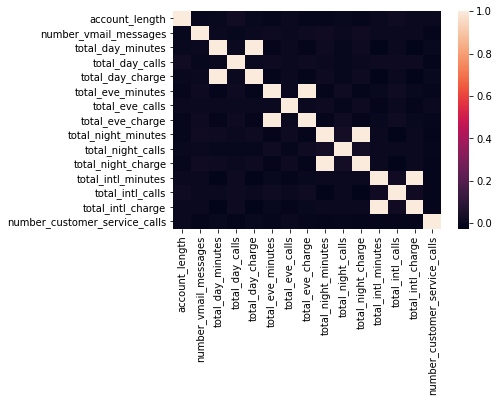

In [313]:
#Evaluating the correlation between variables
train_corr = train_df.corr()
sns.heatmap(train_corr)
#It's possible to see that every total_charge is completely related to its total_minutes

In [314]:
#Evaluating the possibility to reduce columns linearly dependendts 
train_df['total_day_charge_per_min'] = train_df['total_day_charge']/train_df['total_day_minutes']
train_df['total_eve_charge_per_min'] = train_df['total_eve_charge']/train_df['total_eve_minutes']
train_df['total_night_charge_per_min'] = train_df['total_night_charge']/train_df['total_night_minutes']
train_df['total_intl_charge_per_min'] = train_df['total_intl_charge']/train_df['total_intl_minutes']

In [315]:
#Evaluating the influence of area_code, state in charging, but the price rates are fixed
train_df[['area_code','state','total_intl_charge_per_min','total_day_charge_per_min','total_eve_charge_per_min','total_night_charge_per_min']].head()

,area_code,state,total_intl_charge_per_min,total_day_charge_per_min,total_eve_charge_per_min,total_night_charge_per_min
0,area_code_415,OH,0.270073,0.169988,0.085013,0.045008
1,area_code_415,NJ,0.269672,0.170008,0.084983,0.045018
2,area_code_408,OH,0.269697,0.170007,0.084976,0.044997
3,area_code_415,OK,0.270297,0.170006,0.085030,0.044997
4,area_code_510,MA,0.270667,0.169982,0.084993,0.045014


In [316]:
#Like the columns added didn't have much to add, they were dropped
train_df = train_df.drop(['total_day_charge_per_min',
       'total_eve_charge_per_min', 'total_night_charge_per_min',
       'total_intl_charge_per_min'],axis=1)

In [317]:
#pd.set_option('display.max_rows',None)
train_df.groupby('state')['churn'].value_counts()


state  churn
AK     no        57
       yes        4
AL     no        88
       yes       13
AR     no        60
       yes       11
AZ     no        70
       yes        7
CA     no        29
       yes       10
CO     no        71
       yes        9
CT     no        73
       yes       15
DC     no        64
       yes        8
DE     no        67
       yes       13
FL     no        67
       yes        9
GA     no        57
       yes        7
HI     no        73
       yes        4
IA     no        55
       yes        7
ID     no        94
       yes       12
IL     no        73
       yes        6
IN     no        70
       yes       13
KS     no        72
       yes       15
KY     no        73
       yes       12
LA     no        62
       yes        7
MA     no        75
       yes       14
MD     no        67
       yes       19
ME     no        73
       yes       16
MI     no        72
       yes       15
MN     no        89
       yes       19
MO     no        70
       

In [318]:
train_df.groupby('area_code')['churn'].value_counts().value_counts()
#considering that these area codes don't correspond to the all areas from USA, this row gonna be deleted

152     1
897     1
159     1
1821    1
934     1
287     1
Name: churn, dtype: int64

In [319]:
state_yes_churn = churn_yes.groupby('state')['churn'].value_counts().sort_values(ascending=False)
state_yes_churn_df = state_yes_churn.to_frame().reset_index(level=1, drop=True)
state_yes_churn_df

,churn
state,
NJ,26
TX,19
MN,19
WV,19
MD,19
WA,18
NV,17
MT,17
ME,16


*Processing the data:*

In [320]:
#The 'total_minutes' columns were dropped because they cause redundancy with "Total_charge" columns
train_df = train_df.drop(['total_day_minutes','total_eve_minutes','total_night_minutes','total_intl_minutes'], axis=1)
train_df.columns

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_calls',
       'total_day_charge', 'total_eve_calls', 'total_eve_charge',
       'total_night_calls', 'total_night_charge', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls', 'churn'],
      dtype='object')

array([[<AxesSubplot:title={'center':'account_length'}>,
        <AxesSubplot:title={'center':'number_vmail_messages'}>,
        <AxesSubplot:title={'center':'total_day_calls'}>],
       [<AxesSubplot:title={'center':'total_day_charge'}>,
        <AxesSubplot:title={'center':'total_eve_calls'}>,
        <AxesSubplot:title={'center':'total_eve_charge'}>],
       [<AxesSubplot:title={'center':'total_night_calls'}>,
        <AxesSubplot:title={'center':'total_night_charge'}>,
        <AxesSubplot:title={'center':'total_intl_calls'}>],
       [<AxesSubplot:title={'center':'total_intl_charge'}>,
        <AxesSubplot:title={'center':'number_customer_service_calls'}>,
        <AxesSubplot:>]], dtype=object)

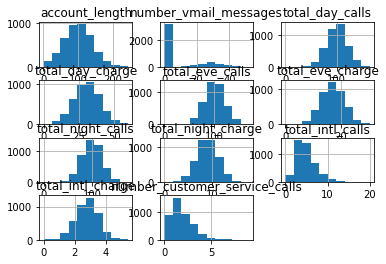

In [321]:
#Evaluating if the variables are normalized. vmail_msgs, international_calls and cust_serv_calls 
#are non-normalized
train_df.hist()


Processing for Model

In [346]:
def processing_for_model(churn_data):
    """
    This function makes the data processing for future modeling, dealing with categorical
    variables, dropping unnecessary rows, reescaling, and splitting the data in target and non-target.
    INPUT: DATASET (Dataframe)
    OUTPUT:X_processed_data, the y_target column and as colunas de X.    
    """
    #Binary encoding of categorical variables
    churn_data['international_plan'] = churn_data['international_plan'].replace({'no':0,'yes':1})
    churn_data['voice_mail_plan'] = churn_data['voice_mail_plan'].replace({'no':0,'yes':1})
    churn_data['churn'] = churn_data['churn'].replace({'no':0,'yes':1})
    #One hot encoding 
    processed_data = pd.concat([pd.get_dummies(churn_data['state']),churn_data],axis=1)
    #Dropping 'state' row after its enconding and 'area_code' row that doesn't impact on churn
    processed_data = processed_data.drop(['area_code','state'], axis=1)
    #Getting the target churn column
    if 'churn' in processed_data.columns:
        y_target = processed_data['churn']
        X_processed_data = processed_data.drop(['churn'],axis=1)
    else:
        y_target = 0
        X_processed_data = processed_data
    #Getting the columns names of X
    X_cols = X_processed_data.columns
    # Instantiate a Min-Max scaling object
    mm = MinMaxScaler()
    # Fit and transform our feature data into a pandas dataframe
    X_processed_data = pd.DataFrame(mm.fit_transform(X_processed_data))
    return X_processed_data,y_target, X_cols

In [348]:
X_train_processed,y_train_target, X_cols_train = processing_for_model(train_df)

#Splitting the training set into X_train and X_test; used 25% of data for test
X_train, X_test, y_train, y_test = train_test_split(X_train_processed, y_train_target, test_size = .25, random_state = 42)


Building the Logistic regression model

In [349]:
# Instantiate a logistic regression model without an intercept, arbitrarily large C value will offset the lack of intercept
logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver= 'liblinear')
# Fit the model to our X and y training sets
logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [350]:
#Getting the model first results for the training dataset
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

Model Performance

In [357]:
# Find residual differences between train data and predicted train data
residuals = np.abs(y_train, y_hat_train)

# Print the number of times our model was correct ('0') and incorrect ('1')
print(pd.Series(residuals).value_counts())
      
# Print normalized amount of times our model was correct (percentage)
print(pd.Series(residuals).value_counts(normalize = True))

0    2745
1     442
Name: churn, dtype: int64
0    0.861312
1    0.138688
Name: churn, dtype: float64


In [359]:
# Find residual differences between test data and predicted test data
residuals_test = np.abs(y_test, y_hat_test)

# Print the number of times our model was correct ('0') and incorrect ('1')
print(pd.Series(residuals_test).value_counts())
      
# Print normalized amount of times our model was correct (percentage)
print(pd.Series(residuals_test).value_counts(normalize = True))

0    907
1    156
Name: churn, dtype: int64
0    0.853246
1    0.146754
Name: churn, dtype: float64


In [363]:
# Pass actual test and predicted target test outcomes to function
cnf_matrix = confusion_matrix(y_test, y_hat_test)
cnf_matrix

array([[907,   0],
       [  0, 156]])

In [369]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
precision_train = precision_score(y_train, y_hat_train)
precision_test = precision_score(y_test, y_hat_test)
recall_train = recall_score(y_train, y_hat_train)
recall_test = recall_score(y_test, y_hat_test)
accuracy_train = accuracy_score(y_train, y_hat_train)
accuracy_test = accuracy_score(y_test, y_hat_test)
f1_train = f1_score(y_train, y_hat_train)
f1_test = f1_score(y_test, y_hat_test)

In [371]:
accuracy_train

1.0